<a href="https://colab.research.google.com/github/marcinabram/learning_and_forgetting_in_neural_networks/blob/main/FederatedLearning_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import sklearn.metrics
import tensorflow
import time
import numpy as np
# Graphic libraries
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
"""Load some data."""
(xraw_train, yraw_train), (xraw_test, yraw_test) = tensorflow.keras.datasets.cifar10.load_data()

xraw_train.shape, yraw_train.shape, xraw_test.shape, yraw_test.shape, xraw_train.dtype, xraw_train.max()

170498071/170498071 [==============================] - 6s 0us/step


((50000, 32, 32, 3),
 (50000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 dtype('uint8'),
 255)

In [3]:
"""Preprocess the data.

In addition, shuffle the data.
Set the random seed (so we can replicate the experiment).
"""
batch_size = 32

# Training Set
x_train_all = xraw_train.astype('float32').reshape(-1, 32, 32, 3)/255
y_train_all = tensorflow.one_hot(yraw_train, 10).numpy().astype('int32')
y_train_all = np.squeeze(y_train_all,axis=1)
print(x_train_all.shape)
print(y_train_all.shape)

print(y_train_all[0])
train_dataset = tensorflow.data.Dataset.from_tensor_slices((x_train_all, y_train_all))
train_dataset = train_dataset.shuffle(buffer_size=1024, seed=56).batch(batch_size)

# Validation Set
x_valid_all = xraw_test.astype('float32').reshape(-1, 32, 32, 3)/255
y_valid_all = tensorflow.one_hot(yraw_test, 10).numpy().astype('int32')
y_valid_all = np.squeeze(y_valid_all,axis=1)
print(x_valid_all.shape)
print(y_valid_all.shape)
valid_dataset = tensorflow.data.Dataset.from_tensor_slices((x_valid_all, y_valid_all)).batch(batch_size)

(50000, 32, 32, 3)
(50000, 10)
[0 0 0 0 0 0 1 0 0 0]
(10000, 32, 32, 3)
(10000, 10)


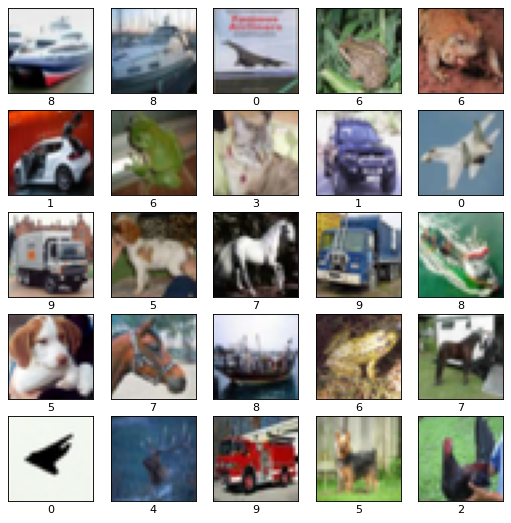

In [4]:
"""Show examples."""
class_names = list(range(10))
offset = 1
one_batch = next(iter(valid_dataset.take(1)))

plt.figure(figsize=(8, 8), dpi=80)
for i in range(25):
    plt.subplot(5, 5, i+1)
    x, y = one_batch
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(x[i + offset], cmap=plt.cm.binary)
    plt.xlabel(class_names[numpy.argmax(y[i + offset])])

plt.show()

In [5]:
class Learner:

    def __init__(self, train_dataset, valid_dataset):
        """Initialization."""
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset

        self.model = self._build_model()
        self.optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
        self.loss_function = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.train_acc_metric = tensorflow.keras.metrics.CategoricalAccuracy()
        self.valid_acc_metric = tensorflow.keras.metrics.CategoricalAccuracy()

        # Logs and counters
        self.training_batches = 0
        self.logs = []

    @staticmethod
    def _build_model():
        """Build model."""
        inputs = tensorflow.keras.Input(shape=(32, 32, 3), name="cifar")
        x = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
        x = tensorflow.keras.layers.MaxPooling2D((2,2))(x)
        x = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
        x = tensorflow.keras.layers.MaxPooling2D((2,2))(x)
        x = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
        x = tensorflow.keras.layers.Flatten()(x)
        x = tensorflow.keras.layers.Dense(64, activation="relu")(x)
        outputs = tensorflow.keras.layers.Dense(10, name="predictions")(x)  # linear activation!
        return tensorflow.keras.Model(inputs=inputs, outputs=outputs, name=f'CustomModel')

    def train(self, batches=-1, log=False, verbose=False,epochs=1):
        """Train several batches."""
        epoch_mean_loss = 0
        epoch_train_acc = 0
        epoch_loss_log = []
        epoch_acc_log = []

        for epoch in range(epochs):
          start_time = time.time()

          loss_log = []

          for x_batch_train, y_batch_train in self.train_dataset.take(batches):
              self.training_batches += 1
              loss_value = self._train_step(x_batch_train, y_batch_train)
              loss_log.append(loss_value)
          mean_loss = numpy.mean(loss_log)
          epoch_loss_log.append(mean_loss)

          train_acc = float(self.train_acc_metric.result())
          epoch_acc_log.append(train_acc)
          self.train_acc_metric.reset_states()

          if verbose:
              print("epoch : ",epoch,"\n")
              print(f'Training acc: {train_acc:.4f}')
              print(f'Time taken to complete training: {time.time() - start_time:.2f} s')
          if log:
              self.logs.append({
                  'type': 'training', 'training_batches':  self.training_batches,
                  'mean_training_loss': mean_loss, 'training_acccuracy': train_acc})

        last_epoch_loss = epoch_loss_log[-1]
        last_epoch_acc = epoch_acc_log[-1]

        return last_epoch_loss,last_epoch_acc


    @tensorflow.function
    def _train_step(self, x, y):
        """Perform one step of training."""
        with tensorflow.GradientTape() as tape:
            logits = self.model(x, training=True)
            loss_value = self.loss_function(y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, logits)
        return loss_value

    def validate(self, log=False, verbose=False):
        """Validate model."""
        start_time = time.time()

        loss_log = []
        for x_batch_val, y_batch_val in self.valid_dataset:
            loss_value = self._valid_step(x_batch_val, y_batch_val)
            loss_log.append(loss_value)
        mean_loss = numpy.mean(loss_log)

        valid_acc = float(self.valid_acc_metric.result())
        self.valid_acc_metric.reset_states()

        if verbose:
            print(f'Validation acc: {valid_acc:.4f}')
            print(f'Time taken to complete validation: {time.time() - start_time:.2f} s')
        if log:
            self.logs.append({
                'type': 'validation', 'training_batches':  self.training_batches,
                'mean_validation_loss': mean_loss, 'vaidation_accuracy': valid_acc})

        return mean_loss, valid_acc

    @tensorflow.function
    def _valid_step(self, x, y):
        logits = self.model(x, training=False)
        self.valid_acc_metric.update_state(y, logits)
        return self.loss_function(y, logits)

    def get_confusion_matrix(self, verbose=False):
        """Prepare confussion matrix."""
        val_logits, val_labels = [], []
        for x_batch_val, y_batch_val in self.valid_dataset:
            logits = self.model(x_batch_val, training=False)
            val_logits.append(logits.numpy())
            val_labels.append(y_batch_val)
        val_logits = numpy.vstack(val_logits)
        val_labels = numpy.vstack(val_labels)

        val_logits = numpy.argmax(val_logits, axis=-1)
        val_labels = numpy.argmax(val_labels, axis=-1)

        # y axis shows true labels, x axis shows the predicted labels
        m = sklearn.metrics.confusion_matrix(
            y_true=val_labels, y_pred=val_logits,
            labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

        if verbose:
            print('Accuracy:', sklearn.metrics.accuracy_score(val_logits, val_labels))

        return m

    def plot_weights_values(self, layer, xdim=None, scale=None, verbose=False, zoom=False):
        """Show the values of the weights in one layer."""
        weights = self.model.get_weights()[layer]
        if not scale:
            scale = numpy.abs(weights.flatten()).max()
        if xdim:
            print(f'--> Reshaping {weights.shape}...')
            weights = weights.reshape((xdim, -1))
        if len(weights.shape) != 2:
            print(f'--> Reshaping {weights.shape}...')
            weights = weights.reshape((-1, weights.shape[-1]))
        if zoom:
            a, b, c, d = zoom
            weights = weights[a:b,c:d]

        plt.figure(dpi=100, figsize=(5, 5))
        plt.imshow(weights, cmap='bwr', interpolation='none', vmin=-scale, vmax=scale)
        plt.show()

        if verbose:
            print(f'Scale from {-scale} to {scale}')
            nonzero = numpy.abs(weights.flatten()) > 10**(-5)
            print(f'Proportion of non-zero weights: {sum(nonzero)/len(nonzero)}')

In [6]:
student = Learner(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset
)
student.model.summary()

Model: "CustomModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cifar (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          

In [7]:
student.train(2000, verbose=True, log=True,epochs=8)

epoch :  0 

Training acc: 0.4479
Time taken to complete training: 15.41 s
epoch :  1 

Training acc: 0.5912
Time taken to complete training: 5.71 s
epoch :  2 

Training acc: 0.6533
Time taken to complete training: 5.15 s
epoch :  3 

Training acc: 0.6863
Time taken to complete training: 10.64 s
epoch :  4 

Training acc: 0.7129
Time taken to complete training: 5.57 s
epoch :  5 

Training acc: 0.7312
Time taken to complete training: 5.43 s
epoch :  6 

Training acc: 0.7456
Time taken to complete training: 5.10 s
epoch :  7 

Training acc: 0.7626
Time taken to complete training: 5.80 s


(0.6799943, 0.7626199722290039)

In [8]:
student.validate(verbose=True,log=True)

Validation acc: 0.7089
Time taken to complete validation: 0.86 s


(0.8736348, 0.708899974822998)

In [9]:
partial_train_dataset = {}
for i in range(4):
    n, k = 10_000*i, 10_000*(i+1)
    partial_train_dataset[i] = tensorflow.data.Dataset.from_tensor_slices(
        (x_train_all[n:k], y_train_all[n:k])).shuffle(buffer_size=1024, seed=56).batch(batch_size)

partial_valid_dataset = {}
for i in range(4):
    n, k = 1_000*i, 1_000*(i+1)
    partial_valid_dataset[i] = tensorflow.data.Dataset.from_tensor_slices(
        (x_valid_all[n:k], y_valid_all[n:k])).batch(batch_size)

In [10]:
client = {}
for i in range(4):
    client[i] = Learner(
        train_dataset=partial_train_dataset[i],
        valid_dataset=partial_valid_dataset[i]
    )

In [11]:
community = Learner(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset
)

In [12]:
for r in range(20):
    print(f'\n*** Round {r}')

    print(f'--- Distributing Weights Among Clients')
    for c in range(4):
        client[c].model.set_weights(community.model.get_weights())

    for c in range(4):
        print(f'--- Training Client {c}')
        client[c].train(verbose=True, log=True,epochs=3)
        client[c].validate(verbose=True, log=True)

    print(f'--- Collecting Weights')
    weights = [[] for _ in range(len(community.model.get_weights()))]
    for c in range(4):
        for i, w in enumerate(client[c].model.get_weights()):
            weights[i].append(w)

    print(f'--- Averaging Weights')
    averaged = [numpy.array(w).mean(axis=0) for w in weights]

    print(f'--- Sending Weights to the Community Model ')
    community.model.set_weights(averaged)
    community.validate(verbose=True, log=True)


*** Round 0
--- Distributing Weights Among Clients
--- Training Client 0
epoch :  0 

Training acc: 0.2875
Time taken to complete training: 2.56 s
epoch :  1 

Training acc: 0.4367
Time taken to complete training: 1.09 s
epoch :  2 

Training acc: 0.4914
Time taken to complete training: 1.46 s
Validation acc: 0.5150
Time taken to complete validation: 1.49 s
--- Training Client 1
epoch :  0 

Training acc: 0.2853
Time taken to complete training: 2.60 s
epoch :  1 

Training acc: 0.4311
Time taken to complete training: 1.05 s
epoch :  2 

Training acc: 0.5041
Time taken to complete training: 1.06 s
Validation acc: 0.4960
Time taken to complete validation: 0.31 s
--- Training Client 2
epoch :  0 

Training acc: 0.2805
Time taken to complete training: 2.54 s
epoch :  1 

Training acc: 0.4292
Time taken to complete training: 1.08 s
epoch :  2 

Training acc: 0.4922
Time taken to complete training: 1.11 s
Validation acc: 0.4800
Time taken to complete validation: 0.24 s
--- Training Client 3

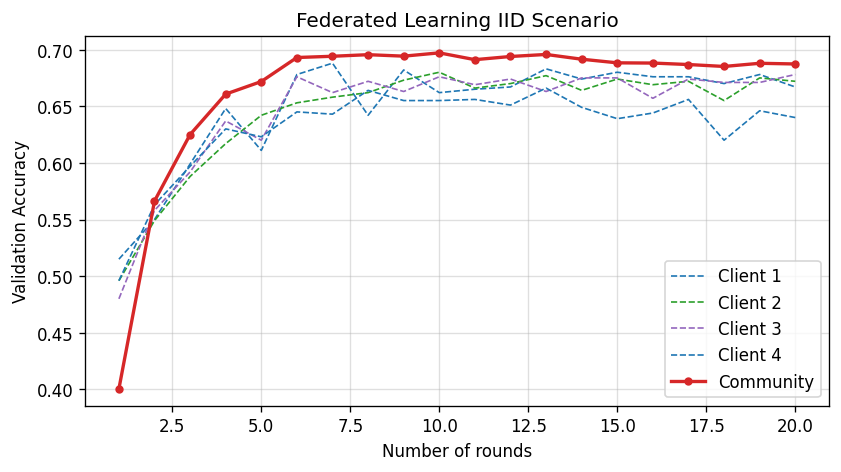

In [13]:
plt.figure(dpi=120, figsize=(8, 4))

# Client
y1 = [log['vaidation_accuracy'] for log in client[0].logs if log['type'] == 'validation']
y2 = [log['vaidation_accuracy'] for log in client[1].logs if log['type'] == 'validation']
y3 = [log['vaidation_accuracy'] for log in client[2].logs if log['type'] == 'validation']
y4 = [log['vaidation_accuracy'] for log in client[3].logs if log['type'] == 'validation']
x = numpy.array(range(len(y1))) + 1
plt.plot(x, y1, '--', color='tab:blue', label='Client 1', lw=1)
plt.plot(x, y2, '--', color='tab:green', label='Client 2', lw=1)
plt.plot(x, y3, '--', color='tab:purple', label='Client 3', lw=1)
plt.plot(x, y4, '--', color='tab:blue', label='Client 4', lw=1)

# Community
x = (numpy.array(range(len(community.logs))) + 1)
y = [log['vaidation_accuracy'] for log in community.logs]
plt.plot(x, y, 'o-', color='tab:red', label='Community', lw=2, ms=4)

plt.title('Federated Learning IID Scenario')
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of rounds')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

# Non - IID


In [14]:
labels = numpy.argmax(y_train_all, axis=-1)
a = (labels == 0) | (labels == 1) | (labels == 2)
b = (labels == 3) | (labels == 4)
c = (labels == 5) | (labels == 6)
d = (labels == 7) | (labels == 8) | (labels == 9)

In [15]:
partial_train_dataset = {}
partial_local_val_dataset = {}
for i, s in enumerate([a, b, c, d]):
    print("Shape ",x_train_all[s].shape)
    split_point = int(0.8*x_train_all[s].shape[0])
    x_train_all_split = x_train_all[s][:split_point,:]
    y_train_all_split = y_train_all[s][:split_point,:]
    x_val_all_split = x_train_all[s][split_point:,:]
    y_val_all_split = y_train_all[s][split_point:,:]
    print("X train ",x_train_all_split.shape)
    print("X val ",x_val_all_split.shape)
    partial_train_dataset[i] = tensorflow.data.Dataset.from_tensor_slices(
        (x_train_all_split, y_train_all_split)).shuffle(buffer_size=1024, seed=56).batch(batch_size)
    partial_local_val_dataset[i] = tensorflow.data.Dataset.from_tensor_slices(
        (x_val_all_split,y_val_all_split)).shuffle(buffer_size=1024, seed=56).batch(batch_size)

print("Element : ",partial_train_dataset[0])
print("Type : ",type(partial_train_dataset))
partial_valid_dataset = {}
for i in range(4):
    n, k = 1_000*i, 1_000*(i+1)
    partial_valid_dataset[i] = tensorflow.data.Dataset.from_tensor_slices(
        (x_valid_all[n:k], y_valid_all[n:k])).batch(batch_size)

Shape  (15000, 32, 32, 3)
X train  (12000, 32, 32, 3)
X val  (3000, 32, 32, 3)
Shape  (10000, 32, 32, 3)
X train  (8000, 32, 32, 3)
X val  (2000, 32, 32, 3)
Shape  (10000, 32, 32, 3)
X train  (8000, 32, 32, 3)
X val  (2000, 32, 32, 3)
Shape  (15000, 32, 32, 3)
X train  (12000, 32, 32, 3)
X val  (3000, 32, 32, 3)
Element :  <_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None))>
Type :  <class 'dict'>


In [16]:
client = {}
unfederated_client = {}
for i in range(4):
    client[i] = Learner(
        train_dataset=partial_train_dataset[i],
        valid_dataset=partial_valid_dataset[i]
    )
    unfederated_client[i] = Learner(
        train_dataset = partial_train_dataset[i],
        valid_dataset = partial_valid_dataset[i]

    )

In [17]:
community = Learner(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset
)

In [18]:
for r in range(20):
    print(f'\n*** Round {r}')

    print(f'--- Distributing Weights Among Clients')
    for c in range(4):
        client[c].model.set_weights(community.model.get_weights())

    for c in range(4):
        print(f'--- Training Client : Federated unit {c}')
        client[c].train(verbose=True, log=True,epochs=3)
        client[c].validate(verbose=True, log=True)
        print(f'--- Training Client : Unfederated unit {c}')
        unfederated_client[c].train(verbose=True,log=True,epochs=3)
        unfederated_client[c].validate(verbose=True,log=True)

    print(f'--- Collecting Weights')
    weights = [[] for _ in range(len(community.model.get_weights()))]
    for c in range(4):
        for i, w in enumerate(client[c].model.get_weights()):
            weights[i].append(w)

    print(f'--- Averaging Weights')
    averaged = [
        0.6*c + 0.4*numpy.array(w).mean(axis=0)
        for c, w in zip(community.model.get_weights(), weights)]

    print(f'--- Sending Weights to the Community Model ')
    community.model.set_weights(averaged)
    community.validate(verbose=True, log=True)


*** Round 0
--- Distributing Weights Among Clients
--- Training Client : Federated unit 0
epoch :  0 

Training acc: 0.6618
Time taken to complete training: 5.21 s
epoch :  1 

Training acc: 0.7988
Time taken to complete training: 1.28 s
epoch :  2 

Training acc: 0.8244
Time taken to complete training: 1.26 s
Validation acc: 0.2450
Time taken to complete validation: 0.23 s
--- Training Client : Unfederated unit 0
epoch :  0 

Training acc: 0.6708
Time taken to complete training: 2.44 s
epoch :  1 

Training acc: 0.8047
Time taken to complete training: 1.24 s
epoch :  2 

Training acc: 0.8411
Time taken to complete training: 1.26 s
Validation acc: 0.2430
Time taken to complete validation: 0.23 s
--- Training Client : Federated unit 1
epoch :  0 

Training acc: 0.6206
Time taken to complete training: 2.88 s
epoch :  1 

Training acc: 0.7806
Time taken to complete training: 0.85 s
epoch :  2 

Training acc: 0.8191
Time taken to complete training: 0.84 s
Validation acc: 0.1740
Time taken

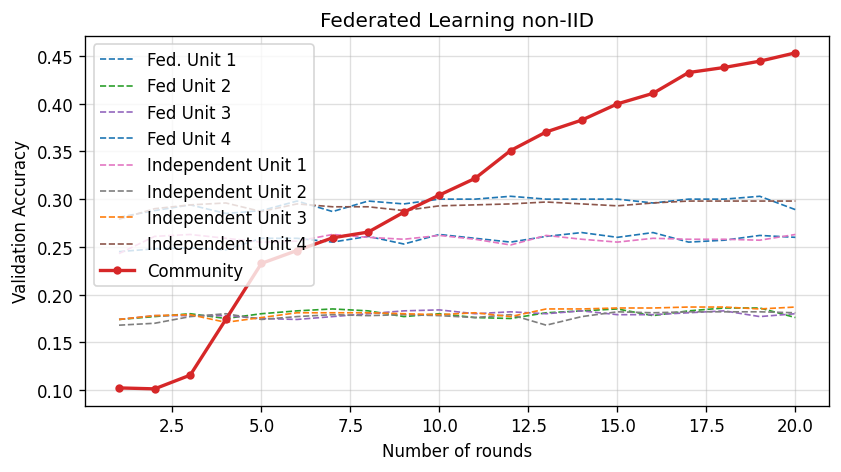

In [19]:
plt.figure(dpi=120, figsize=(8, 4))

# Client
y1 = [log['vaidation_accuracy'] for log in client[0].logs if log['type'] == 'validation']
y2 = [log['vaidation_accuracy'] for log in client[1].logs if log['type'] == 'validation']
y3 = [log['vaidation_accuracy'] for log in client[2].logs if log['type'] == 'validation']
y4 = [log['vaidation_accuracy'] for log in client[3].logs if log['type'] == 'validation']
#unfederated
y1_uf = [log['vaidation_accuracy'] for log in unfederated_client[0].logs if log['type'] == 'validation']
y2_uf = [log['vaidation_accuracy'] for log in unfederated_client[1].logs if log['type'] == 'validation']
y3_uf = [log['vaidation_accuracy'] for log in unfederated_client[2].logs if log['type'] == 'validation']
y4_uf = [log['vaidation_accuracy'] for log in unfederated_client[3].logs if log['type'] == 'validation']



x = numpy.array(range(len(y1))) + 1
plt.plot(x, y1, '--', color='tab:blue', label='Fed. Unit 1', lw=1)
plt.plot(x, y2, '--', color='tab:green', label='Fed Unit 2', lw=1)
plt.plot(x, y3, '--', color='tab:purple', label='Fed Unit 3', lw=1)
plt.plot(x, y4, '--', color='tab:blue', label='Fed Unit 4', lw=1)

plt.plot(x, y1_uf, '--', color='tab:pink', label='Independent Unit 1', lw=1)
plt.plot(x, y2_uf, '--', color='tab:gray', label='Independent Unit 2', lw=1)
plt.plot(x, y3_uf, '--', color='tab:orange', label='Independent Unit 3', lw=1)
plt.plot(x, y4_uf, '--', color='tab:brown', label='Independent Unit 4', lw=1)

# Community
x = (numpy.array(range(len(community.logs))) + 1)
y = [log['vaidation_accuracy'] for log in community.logs]
plt.plot(x, y, 'o-', color='tab:red', label='Community', lw=2, ms=4)

plt.title('Federated Learning non-IID')
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of rounds')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

#More weightage to meannn

mean_weightage = 0.6

In [20]:
client = {}
unfederated_client = {}
for i in range(4):
    client[i] = Learner(
        train_dataset=partial_train_dataset[i],
        valid_dataset=partial_valid_dataset[i]
    )
    unfederated_client[i] = Learner(
        train_dataset = partial_train_dataset[i],
        valid_dataset = partial_valid_dataset[i]

    )

community = Learner(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset
)

In [21]:
for r in range(20):
    print(f'\n*** Round {r}')

    print(f'--- Distributing Weights Among Clients')
    for c in range(4):
        client[c].model.set_weights(community.model.get_weights())

    for c in range(4):
        print(f'--- Training Client : Federated unit {c}')
        client[c].train(verbose=True, log=True)
        client[c].validate(verbose=True, log=True)
        print(f'--- Training Client : Unfederated unit {c}')
        unfederated_client[c].train(verbose=True,log=True)
        unfederated_client[c].validate(verbose=True,log=True)

    print(f'--- Collecting Weights')
    weights = [[] for _ in range(len(community.model.get_weights()))]
    for c in range(4):
        for i, w in enumerate(client[c].model.get_weights()):
            weights[i].append(w)

    print(f'--- Averaging Weights')
    averaged = [
        0.4*c + 0.6*numpy.array(w).mean(axis=0)
        for c, w in zip(community.model.get_weights(), weights)]

    print(f'--- Sending Weights to the Community Model ')
    community.model.set_weights(averaged)
    community.validate(verbose=True, log=True)


*** Round 0
--- Distributing Weights Among Clients
--- Training Client : Federated unit 0
epoch :  0 

Training acc: 0.6848
Time taken to complete training: 2.93 s
Validation acc: 0.2290
Time taken to complete validation: 0.30 s
--- Training Client : Unfederated unit 0
epoch :  0 

Training acc: 0.6682
Time taken to complete training: 2.43 s
Validation acc: 0.2230
Time taken to complete validation: 0.24 s
--- Training Client : Federated unit 1
epoch :  0 

Training acc: 0.6455
Time taken to complete training: 2.02 s
Validation acc: 0.1550
Time taken to complete validation: 0.22 s
--- Training Client : Unfederated unit 1
epoch :  0 

Training acc: 0.6495
Time taken to complete training: 2.02 s
Validation acc: 0.1460
Time taken to complete validation: 0.23 s
--- Training Client : Federated unit 2
epoch :  0 

Training acc: 0.7075
Time taken to complete training: 2.55 s
Validation acc: 0.1500
Time taken to complete validation: 0.62 s
--- Training Client : Unfederated unit 2
epoch :  0 



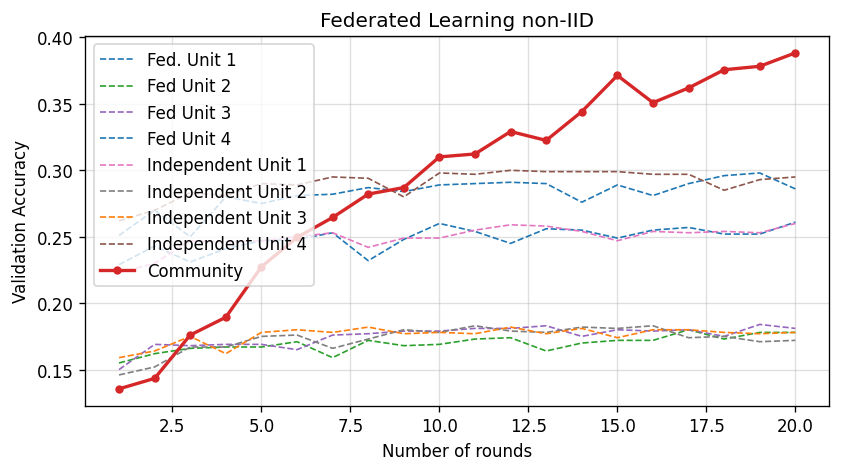

In [22]:
plt.figure(dpi=120, figsize=(8, 4))

# Client
y1 = [log['vaidation_accuracy'] for log in client[0].logs if log['type'] == 'validation']
y2 = [log['vaidation_accuracy'] for log in client[1].logs if log['type'] == 'validation']
y3 = [log['vaidation_accuracy'] for log in client[2].logs if log['type'] == 'validation']
y4 = [log['vaidation_accuracy'] for log in client[3].logs if log['type'] == 'validation']
#unfederated
y1_uf = [log['vaidation_accuracy'] for log in unfederated_client[0].logs if log['type'] == 'validation']
y2_uf = [log['vaidation_accuracy'] for log in unfederated_client[1].logs if log['type'] == 'validation']
y3_uf = [log['vaidation_accuracy'] for log in unfederated_client[2].logs if log['type'] == 'validation']
y4_uf = [log['vaidation_accuracy'] for log in unfederated_client[3].logs if log['type'] == 'validation']



x = numpy.array(range(len(y1))) + 1
# plt.plot(x, y1, '--', color='tab:blue', label='Client 1', lw=1)
# plt.plot(x, y2, '--', color='tab:green', label='Client 2', lw=1)
# plt.plot(x, y3, '--', color='tab:purple', label='Client 3', lw=1)
# plt.plot(x, y4, '--', color='tab:cyan', label='Client 4', lw=1)

# plt.plot(x, y1_uf, '--', color='tab:pink', label='uf_Client 1', lw=1)
# plt.plot(x, y2_uf, '--', color='tab:gray', label='uf_Client 2', lw=1)
# plt.plot(x, y3_uf, '--', color='tab:orange', label='uf_Client 3', lw=1)
# plt.plot(x, y4_uf, '--', color='tab:brown', label='uf_Client 4', lw=1)

plt.plot(x, y1, '--', color='tab:blue', label='Fed. Unit 1', lw=1)
plt.plot(x, y2, '--', color='tab:green', label='Fed Unit 2', lw=1)
plt.plot(x, y3, '--', color='tab:purple', label='Fed Unit 3', lw=1)
plt.plot(x, y4, '--', color='tab:blue', label='Fed Unit 4', lw=1)

plt.plot(x, y1_uf, '--', color='tab:pink', label='Independent Unit 1', lw=1)
plt.plot(x, y2_uf, '--', color='tab:gray', label='Independent Unit 2', lw=1)
plt.plot(x, y3_uf, '--', color='tab:orange', label='Independent Unit 3', lw=1)
plt.plot(x, y4_uf, '--', color='tab:brown', label='Independent Unit 4', lw=1)

# Community
x = (numpy.array(range(len(community.logs))) + 1)
y = [log['vaidation_accuracy'] for log in community.logs]
plt.plot(x, y, 'o-', color='tab:red', label='Community', lw=2, ms=4)

plt.title('Federated Learning non-IID')
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of rounds')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

Mean weightage = 0.8


In [23]:
client = {}
unfederated_client = {}
for i in range(4):
    client[i] = Learner(
        train_dataset=partial_train_dataset[i],
        valid_dataset=partial_valid_dataset[i]
    )
    unfederated_client[i] = Learner(
        train_dataset = partial_train_dataset[i],
        valid_dataset = partial_valid_dataset[i]

    )

community = Learner(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset
)

In [24]:
for r in range(20):
    print(f'\n*** Round {r}')

    print(f'--- Distributing Weights Among Clients')
    for c in range(4):
        client[c].model.set_weights(community.model.get_weights())

    for c in range(4):
        print(f'--- Training Client : Federated unit {c}')
        client[c].train(verbose=True, log=True)
        client[c].validate(verbose=True, log=True)
        print(f'--- Training Client : Unfederated unit {c}')
        unfederated_client[c].train(verbose=True,log=True)
        unfederated_client[c].validate(verbose=True,log=True)

    print(f'--- Collecting Weights')
    weights = [[] for _ in range(len(community.model.get_weights()))]
    for c in range(4):
        for i, w in enumerate(client[c].model.get_weights()):
            weights[i].append(w)

    print(f'--- Averaging Weights')
    averaged = [
        0.2*c + 0.8*numpy.array(w).mean(axis=0)
        for c, w in zip(community.model.get_weights(), weights)]

    print(f'--- Sending Weights to the Community Model ')
    community.model.set_weights(averaged)
    community.validate(verbose=True, log=True)


*** Round 0
--- Distributing Weights Among Clients
--- Training Client : Federated unit 0
epoch :  0 

Training acc: 0.6942
Time taken to complete training: 2.65 s
Validation acc: 0.2210
Time taken to complete validation: 0.24 s
--- Training Client : Unfederated unit 0
epoch :  0 

Training acc: 0.6832
Time taken to complete training: 2.83 s
Validation acc: 0.2310
Time taken to complete validation: 0.25 s
--- Training Client : Federated unit 1
epoch :  0 

Training acc: 0.6270
Time taken to complete training: 5.17 s
Validation acc: 0.1480
Time taken to complete validation: 0.24 s
--- Training Client : Unfederated unit 1
epoch :  0 

Training acc: 0.6561
Time taken to complete training: 2.06 s
Validation acc: 0.1620
Time taken to complete validation: 0.24 s
--- Training Client : Federated unit 2
epoch :  0 

Training acc: 0.7361
Time taken to complete training: 2.06 s
Validation acc: 0.1620
Time taken to complete validation: 0.24 s
--- Training Client : Unfederated unit 2
epoch :  0 



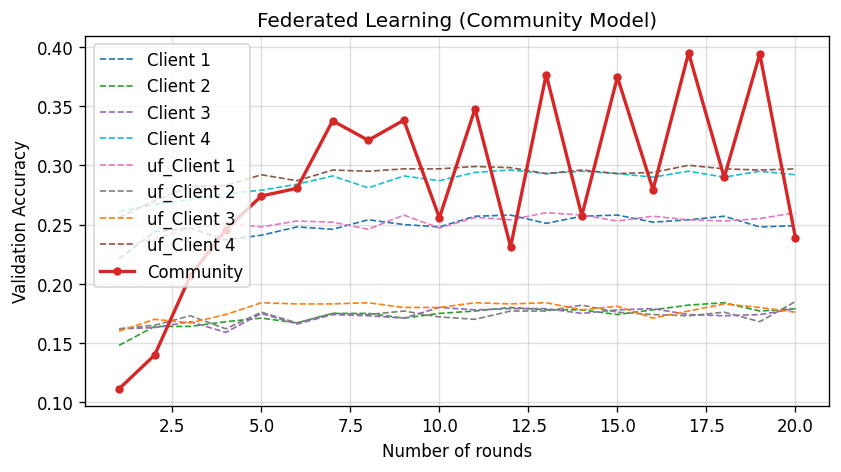

In [25]:
plt.figure(dpi=120, figsize=(8, 4))

# Client
y1 = [log['vaidation_accuracy'] for log in client[0].logs if log['type'] == 'validation']
y2 = [log['vaidation_accuracy'] for log in client[1].logs if log['type'] == 'validation']
y3 = [log['vaidation_accuracy'] for log in client[2].logs if log['type'] == 'validation']
y4 = [log['vaidation_accuracy'] for log in client[3].logs if log['type'] == 'validation']
#unfederated
y1_uf = [log['vaidation_accuracy'] for log in unfederated_client[0].logs if log['type'] == 'validation']
y2_uf = [log['vaidation_accuracy'] for log in unfederated_client[1].logs if log['type'] == 'validation']
y3_uf = [log['vaidation_accuracy'] for log in unfederated_client[2].logs if log['type'] == 'validation']
y4_uf = [log['vaidation_accuracy'] for log in unfederated_client[3].logs if log['type'] == 'validation']



x = numpy.array(range(len(y1))) + 1
plt.plot(x, y1, '--', color='tab:blue', label='Client 1', lw=1)
plt.plot(x, y2, '--', color='tab:green', label='Client 2', lw=1)
plt.plot(x, y3, '--', color='tab:purple', label='Client 3', lw=1)
plt.plot(x, y4, '--', color='tab:cyan', label='Client 4', lw=1)

plt.plot(x, y1_uf, '--', color='tab:pink', label='uf_Client 1', lw=1)
plt.plot(x, y2_uf, '--', color='tab:gray', label='uf_Client 2', lw=1)
plt.plot(x, y3_uf, '--', color='tab:orange', label='uf_Client 3', lw=1)
plt.plot(x, y4_uf, '--', color='tab:brown', label='uf_Client 4', lw=1)

# Community
x = (numpy.array(range(len(community.logs))) + 1)
y = [log['vaidation_accuracy'] for log in community.logs]
plt.plot(x, y, 'o-', color='tab:red', label='Community', lw=2, ms=4)

plt.title('Federated Learning (Community Model)')
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of rounds')
plt.legend()
plt.grid(alpha=0.4)
plt.show()